In [ ]:
# Clone the ibm/tsfm repository
!git clone https://github.com/IBM-granite/granite-tsfm.git
# Change directory to the tsfm repository
%cd granite-tsfm
# Install the tsfm library
!pip install ".[notebooks]"


Cloning into 'granite-tsfm'...
remote: Enumerating objects: 2286, done.
remote: Counting objects: 100% (836/836), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 2286 (delta 603), reused 555 (delta 537), pack-reused 1450
Receiving objects: 100% (2286/2286), 20.17 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (1344/1344), done.
/content/granite-tsfm
Processing /content/granite-tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia

In [ ]:
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Path to your dataset
dataset_path = "/content/combined_dataset.xlsx"

# Load the data
df_tmp = pd.read_excel(dataset_path)
df_tmp['ds'] = pd.to_datetime(df_tmp['ds'])

# Display the first few rows of the dataframe
print(df_tmp.head())

# Define the column specifiers
timestamp_column = "ds"
id_columns = []  # Adjust based on your dataset
target_columns = df_tmp.columns[1:].tolist()

# Define the split configuration
split_config = {
    "train": [0, int(0.6 * len(df_tmp))],
    "valid": [int(0.6 * len(df_tmp)), int(0.8 * len(df_tmp))],
    "test": [int(0.8 * len(df_tmp)), len(df_tmp)],
}

                   ds     AREA13     AREA17    AREA18     AREA19      AREA20  \
0 2011-01-01 00:00:00  88.074635  72.479303  18.82104  138.61838  257.857343   
1 2011-01-01 01:00:00  85.638316  71.626921  18.08736  137.12338  254.185227   
2 2011-01-01 02:00:00  84.130155  70.904240  17.47680  135.78402  251.299487   
3 2011-01-01 03:00:00  83.078551  69.762638  17.08464  134.79082  246.884896   
4 2011-01-01 04:00:00  83.425287  69.225483  16.79184  133.73284  244.874204   

     AREA21    AREA22     AREA23     AREA24  ...     AREA57       AREA6  \
0  84.96768  27.27024  26.277332  61.375534  ...  59.015744  985.524051   
1  83.56032  26.63632  25.391039  61.292160  ...  56.509702  939.363308   
2  82.72968  26.59756  25.011245  60.986664  ...  54.802931  902.659208   
3  82.10364  26.22180  24.679159  60.839997  ...  53.585662  881.018019   
4  81.47784  26.14608  24.679125  61.194108  ...  53.058469  873.526001   

        AREA60      Calgary      Central     Edmonton    Northeast  

In [ ]:
data = df_tmp.copy()
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=512,
    prediction_length=96,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=0.05, fewshot_location="first"
)

print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

# Load the pre-trained model
TTM_MODEL_REVISION = "main"
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION)
zeroshot_model

# Set up a temporary directory for outputs
temp_dir = tempfile.mkdtemp()

# Zero-shot evaluation
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)
zeroshot_output = zeroshot_trainer.evaluate(test_dataset)
print("Zero-shot evaluation output:", zeroshot_output)

<ipython-input-7-c53994516bb5>:18: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


Data lengths: train = 1, val = 1, test = 1


Zero-shot evaluation output: {'eval_loss': 1.312071681022644, 'eval_model_preparation_time': 0.0129, 'eval_runtime': 0.0427, 'eval_samples_per_second': 23.431, 'eval_steps_per_second': 23.431}


TypeError: 'Axes' object is not subscriptable

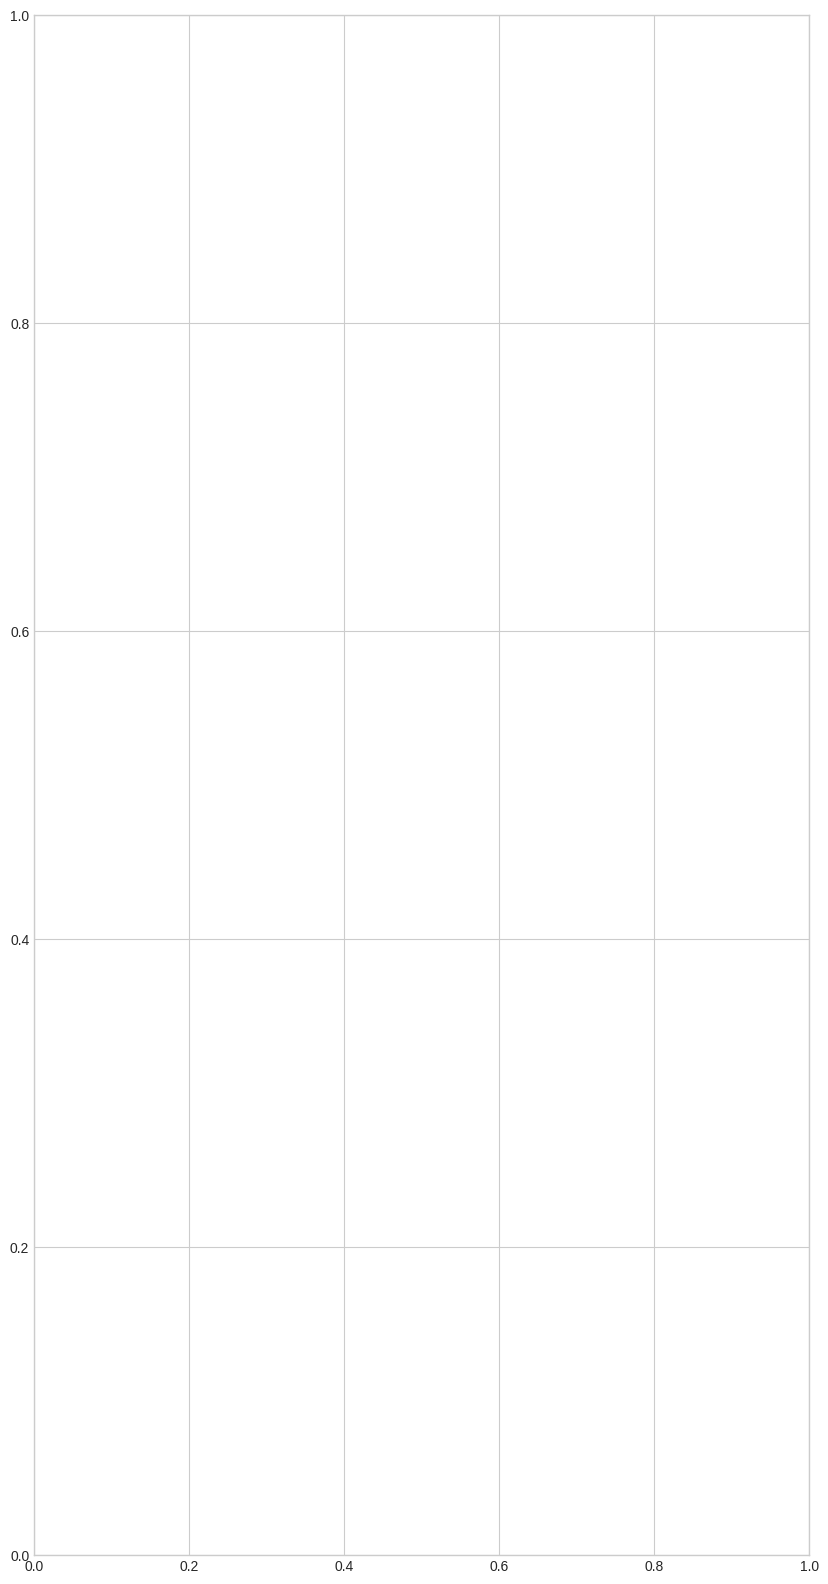

In [ ]:
num_plots = min(10, len(test_dataset))

# Plot zero-shot predictions
plot_preds(trainer=zeroshot_trainer, dset=test_dataset, plot_dir=os.path.join(temp_dir, "your_dataset"), plot_prefix="test_zeroshot", channel=0, num_plots=num_plots)

# Few-shot fine-tuning
# Freeze the backbone of the model
for param in zeroshot_model.parameters():
    param.requires_grad = False

# Define training arguments for fine-tuning
finetune_forecast_args = TrainingArguments(
    output_dir=temp_dir,
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
)

# Define optimizer and scheduler
optimizer = AdamW(zeroshot_model.parameters(), lr=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=1e-4, total_steps=100)

# Set up the trainer for fine-tuning
finetune_trainer = Trainer(
    model=zeroshot_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), TrackingCallback()],
    optimizers=(optimizer, scheduler),
)

# Fine-tune the model
finetune_trainer.train()

# Evaluate the model after fine-tuning
fewshot_output = finetune_trainer.evaluate(test_dataset)
print("Few-shot evaluation output:", fewshot_output)

In [ ]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Path to your dataset
dataset_path = "combined_dataset.xlsx"

# Load the data
df_tmp = pd.read_excel(dataset_path)
df_tmp['ds'] = pd.to_datetime(df_tmp['ds'])

# Display the first few rows of the dataframe
print(df_tmp.head())

# Define the column specifiers
timestamp_column = "ds"
id_columns = []  # Adjust based on your dataset
target_columns = df_tmp.columns[1:].tolist()

# Define the split configuration
split_config = {
    "train": [0, int(0.6 * len(df_tmp))],
    "valid": [int(0.6 * len(df_tmp)), int(0.8 * len(df_tmp))],
    "test": [int(0.8 * len(df_tmp)), len(df_tmp)],
}

# Preprocess the dataset
data = df_tmp.copy()
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=512,
    prediction_length=96,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=0.05, fewshot_location="first"
)

print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

# Load the pre-trained model
TTM_MODEL_REVISION = "main"
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION)
zeroshot_model

# Set up a temporary directory for outputs
temp_dir = tempfile.mkdtemp()

# Zero-shot evaluation
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)
zeroshot_output = zeroshot_trainer.evaluate(test_dataset)
print("Zero-shot evaluation output:", zeroshot_output)

# Adjust the number of plots based on the dataset size
num_plots = min(10, len(test_dataset))

# Plot zero-shot predictions
def plot_preds(trainer, dset, plot_dir, num_plots=10, plot_prefix="valid", channel=-1, truncate_history=True):
    device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device("cpu")
    random_indices = np.random.choice(len(dset), size=num_plots, replace=False)
    random_samples = torch.stack([dset[i]["past_values"] for i in random_indices])
    trainer.model = trainer.model.to(device)

    # Get predictions
    with torch.no_grad():
        preds = trainer.model(random_samples.to(device)).cpu()

    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    for i, idx in enumerate(random_indices):
        fig, ax = plt.subplots(figsize=(20, 5))
        sample = dset[idx]["past_values"]
        target = dset[idx]["future_values"]

        if truncate_history:
            sample = sample[-trainer.model.config.context_length:]

        if channel == -1:
            y_true = target.numpy()
            y_hat = preds[i].numpy()
        else:
            y_true = target[:, channel].numpy()
            y_hat = preds[i, :, channel].numpy()

        x = np.arange(len(sample))
        y = np.arange(len(sample), len(sample) + len(target))

        ax.plot(x, sample.numpy(), label="History", color="blue", linewidth=2)
        ax.plot(y, y_true, label="True", color="green", linewidth=2)
        ax.plot(y, y_hat, label="Predicted", linestyle="--", color="orange", linewidth=2)

        ax.set_title(f"{plot_prefix} Sample {i + 1}")
        ax.legend()

        plt.savefig(os.path.join(plot_dir, f"{plot_prefix}_sample_{i + 1}.png"))
        plt.close(fig)

plot_preds(trainer=zeroshot_trainer, dset=test_dataset, plot_dir=os.path.join(temp_dir, "your_dataset"), plot_prefix="test_zeroshot", channel=0, num_plots=num_plots)

# Few-shot fine-tuning
# Freeze the backbone of the model
for param in zeroshot_model.parameters():
    param.requires_grad = False

# Define training arguments for fine-tuning
finetune_forecast_args = TrainingArguments(
    output_dir=temp_dir,
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
)

# Define optimizer and scheduler
optimizer = AdamW(zeroshot_model.parameters(), lr=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=1e-4, total_steps=100)

# Set up the trainer for fine-tuning
finetune_trainer = Trainer(
    model=zeroshot_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), TrackingCallback()],
    optimizers=(optimizer, scheduler),
)

# Fine-tune the model
finetune_trainer.train()

# Evaluate the model after fine-tuning
fewshot_output = finetune_trainer.evaluate(test_dataset)
print("Few-shot evaluation output:", fewshot_output)


                   ds     AREA13     AREA17    AREA18     AREA19      AREA20  \
0 2011-01-01 00:00:00  88.074635  72.479303  18.82104  138.61838  257.857343   
1 2011-01-01 01:00:00  85.638316  71.626921  18.08736  137.12338  254.185227   
2 2011-01-01 02:00:00  84.130155  70.904240  17.47680  135.78402  251.299487   
3 2011-01-01 03:00:00  83.078551  69.762638  17.08464  134.79082  246.884896   
4 2011-01-01 04:00:00  83.425287  69.225483  16.79184  133.73284  244.874204   

     AREA21    AREA22     AREA23     AREA24  ...     AREA57       AREA6  \
0  84.96768  27.27024  26.277332  61.375534  ...  59.015744  985.524051   
1  83.56032  26.63632  25.391039  61.292160  ...  56.509702  939.363308   
2  82.72968  26.59756  25.011245  60.986664  ...  54.802931  902.659208   
3  82.10364  26.22180  24.679159  60.839997  ...  53.585662  881.018019   
4  81.47784  26.14608  24.679125  61.194108  ...  53.058469  873.526001   

        AREA60      Calgary      Central     Edmonton    Northeast  

<ipython-input-11-78c0ba307312>:69: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


Data lengths: train = 3253, val = 22401, test = 22401


Zero-shot evaluation output: {'eval_loss': 0.3252902030944824, 'eval_model_preparation_time': 0.0058, 'eval_runtime': 29.1313, 'eval_samples_per_second': 768.968, 'eval_steps_per_second': 12.049}


AttributeError: 'TinyTimeMixerForPredictionOutput' object has no attribute 'cpu'

                   ds     AREA13     AREA17    AREA18     AREA19      AREA20  \
0 2011-01-01 00:00:00  88.074635  72.479303  18.82104  138.61838  257.857343   
1 2011-01-01 01:00:00  85.638316  71.626921  18.08736  137.12338  254.185227   
2 2011-01-01 02:00:00  84.130155  70.904240  17.47680  135.78402  251.299487   
3 2011-01-01 03:00:00  83.078551  69.762638  17.08464  134.79082  246.884896   
4 2011-01-01 04:00:00  83.425287  69.225483  16.79184  133.73284  244.874204   

     AREA21    AREA22     AREA23     AREA24  ...     AREA57       AREA6  \
0  84.96768  27.27024  26.277332  61.375534  ...  59.015744  985.524051   
1  83.56032  26.63632  25.391039  61.292160  ...  56.509702  939.363308   
2  82.72968  26.59756  25.011245  60.986664  ...  54.802931  902.659208   
3  82.10364  26.22180  24.679159  60.839997  ...  53.585662  881.018019   
4  81.47784  26.14608  24.679125  61.194108  ...  53.058469  873.526001   

        AREA60      Calgary      Central     Edmonton    Northeast  

<ipython-input-12-00b88936b36f>:69: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


Zero-shot evaluation output: {'eval_loss': 1.312071681022644, 'eval_model_preparation_time': 0.0028, 'eval_runtime': 0.0124, 'eval_samples_per_second': 80.479, 'eval_steps_per_second': 80.479}


TypeError: tuple indices must be integers or slices, not tuple

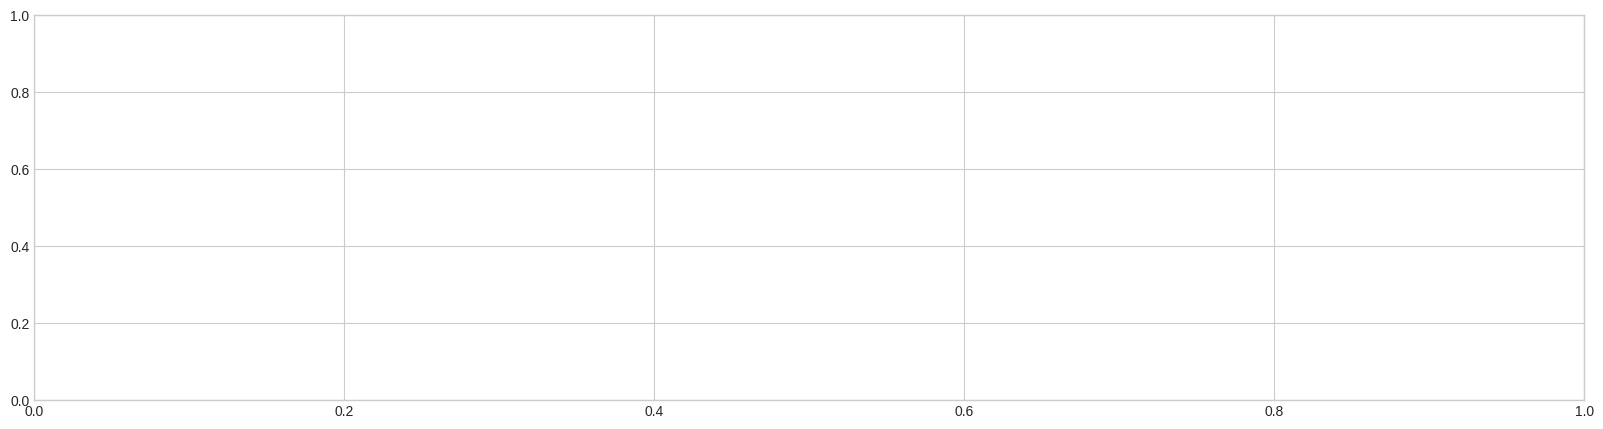

In [ ]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Path to your dataset
dataset_path = "small.xlsx"

# Load the data
df_tmp = pd.read_excel(dataset_path)
df_tmp['ds'] = pd.to_datetime(df_tmp['ds'])

# Display the first few rows of the dataframe
print(df_tmp.head())

# Define the column specifiers
timestamp_column = "ds"
id_columns = []  # Adjust based on your dataset
target_columns = df_tmp.columns[1:].tolist()

# Define the split configuration
split_config = {
    "train": [0, int(0.6 * len(df_tmp))],
    "valid": [int(0.6 * len(df_tmp)), int(0.8 * len(df_tmp))],
    "test": [int(0.8 * len(df_tmp)), len(df_tmp)],
}

# Preprocess the dataset
data = df_tmp.copy()
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=512,
    prediction_length=96,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=0.05, fewshot_location="first"
)

print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

# Load the pre-trained model
TTM_MODEL_REVISION = "main"
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION)
zeroshot_model

# Set up a temporary directory for outputs
temp_dir = tempfile.mkdtemp()

# Zero-shot evaluation
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)
zeroshot_output = zeroshot_trainer.evaluate(test_dataset)
print("Zero-shot evaluation output:", zeroshot_output)

# Adjust the number of plots based on the dataset size
num_plots = min(10, len(test_dataset))

# Plot zero-shot predictions
def plot_preds(trainer, dset, plot_dir, num_plots=10, plot_prefix="valid", channel=-1, truncate_history=True):
    device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device("cpu")
    random_indices = np.random.choice(len(dset), size=num_plots, replace=False)
    random_samples = torch.stack([dset[i]["past_values"] for i in random_indices])
    trainer.model = trainer.model.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = trainer.model(random_samples.to(device))
        preds = outputs.logits.cpu() if hasattr(outputs, 'logits') else outputs

    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    for i, idx in enumerate(random_indices):
        fig, ax = plt.subplots(figsize=(20, 5))
        sample = dset[idx]["past_values"]
        target = dset[idx]["future_values"]

        if truncate_history:
            sample = sample[-trainer.model.config.context_length:]

        if channel == -1:
            y_true = target.numpy()
            y_hat = preds[i].numpy()
        else:
            y_true = target[:, channel].numpy()
            y_hat = preds[i, :, channel].numpy()

        x = np.arange(len(sample))
        y = np.arange(len(sample), len(sample) + len(target))

        ax.plot(x, sample.numpy(), label="History", color="blue", linewidth=2)
        ax.plot(y, y_true, label="True", color="green", linewidth=2)
        ax.plot(y, y_hat, label="Predicted", linestyle="--", color="orange", linewidth=2)

        ax.set_title(f"{plot_prefix} Sample {i + 1}")
        ax.legend()

        plt.savefig(os.path.join(plot_dir, f"{plot_prefix}_sample_{i + 1}.png"))
        plt.close(fig)

plot_preds(trainer=zeroshot_trainer, dset=test_dataset, plot_dir=os.path.join(temp_dir, "your_dataset"), plot_prefix="test_zeroshot", channel=0, num_plots=num_plots)

# Few-shot fine-tuning
# Freeze the backbone of the model
for param in zeroshot_model.parameters():
    param.requires_grad = False

# Define training arguments for fine-tuning
finetune_forecast_args = TrainingArguments(
    output_dir=temp_dir,
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
)

# Define optimizer and scheduler
optimizer = AdamW(zeroshot_model.parameters(), lr=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=1e-4, total_steps=100)

# Set up the trainer for fine-tuning
finetune_trainer = Trainer(
    model=zeroshot_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), TrackingCallback()],
    optimizers=(optimizer, scheduler),
)

# Fine-tune the model
finetune_trainer.train()

# Evaluate the model after fine-tuning
fewshot_output = finetune_trainer.evaluate(test_dataset)
print("Few-shot evaluation output:", fewshot_output)


In [ ]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

# Set seed for reproducibility
SEED = 42
set_seed(SEED)


In [ ]:

# Path to your dataset
dataset_path = "/content/small.xlsx"



In [ ]:
df_tmp = pd.read_excel(dataset_path)
df_tmp['ds'] = pd.to_datetime(df_tmp['ds'])


                   ds     AREA13     AREA17    AREA18     AREA19      AREA20  \
0 2011-01-01 00:00:00  88.074635  72.479303  18.82104  138.61838  257.857343   
1 2011-01-01 01:00:00  85.638316  71.626921  18.08736  137.12338  254.185227   
2 2011-01-01 02:00:00  84.130155  70.904240  17.47680  135.78402  251.299487   
3 2011-01-01 03:00:00  83.078551  69.762638  17.08464  134.79082  246.884896   
4 2011-01-01 04:00:00  83.425287  69.225483  16.79184  133.73284  244.874204   

     AREA21    AREA22     AREA23     AREA24  ...     AREA57       AREA6  \
0  84.96768  27.27024  26.277332  61.375534  ...  59.015744  985.524051   
1  83.56032  26.63632  25.391039  61.292160  ...  56.509702  939.363308   
2  82.72968  26.59756  25.011245  60.986664  ...  54.802931  902.659208   
3  82.10364  26.22180  24.679159  60.839997  ...  53.585662  881.018019   
4  81.47784  26.14608  24.679125  61.194108  ...  53.058469  873.526001   

        AREA60      Calgary      Central     Edmonton    Northeast  

{'eval_loss': 0.6519664525985718, 'eval_runtime': 2.218, 'eval_samples_per_second': 407.129, 'eval_steps_per_second': 6.763}
-------------------- Running few-shot 5% --------------------
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.770000,0.650512
2,0.753300,0.648764
3,0.745000,0.646144
4,0.726400,0.642520
5,0.706400,0.638133
6,0.681300,0.633519
7,0.634700,0.629598
8,0.601700,0.626756
9,0.564900,0.625484
10,0.528600,0.626160


[TrackingCallback] Mean Epoch Time = 0.5953887136358964 seconds, Total Train Time = 56.56423783302307
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.6254839301109314, 'eval_runtime': 2.1213, 'eval_samples_per_second': 425.673, 'eval_steps_per_second': 7.071, 'epoch': 19.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.5411557555198669, 'eval_runtime': 1.608, 'eval_samples_per_second': 561.559, 'eval_steps_per_second': 9.328}
-------------------- Running few-shot 5% --------------------
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.747300,0.540453
2,0.740300,0.539596
3,0.724500,0.538332
4,0.712000,0.536596
5,0.693900,0.534485
6,0.670300,0.532242
7,0.627000,0.530407
8,0.591600,0.529221
9,0.557600,0.529104
10,0.519400,0.530195


[TrackingCallback] Mean Epoch Time = 0.6205781886452123 seconds, Total Train Time = 57.246137619018555
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.5291038751602173, 'eval_runtime': 2.165, 'eval_samples_per_second': 417.083, 'eval_steps_per_second': 6.928, 'epoch': 19.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


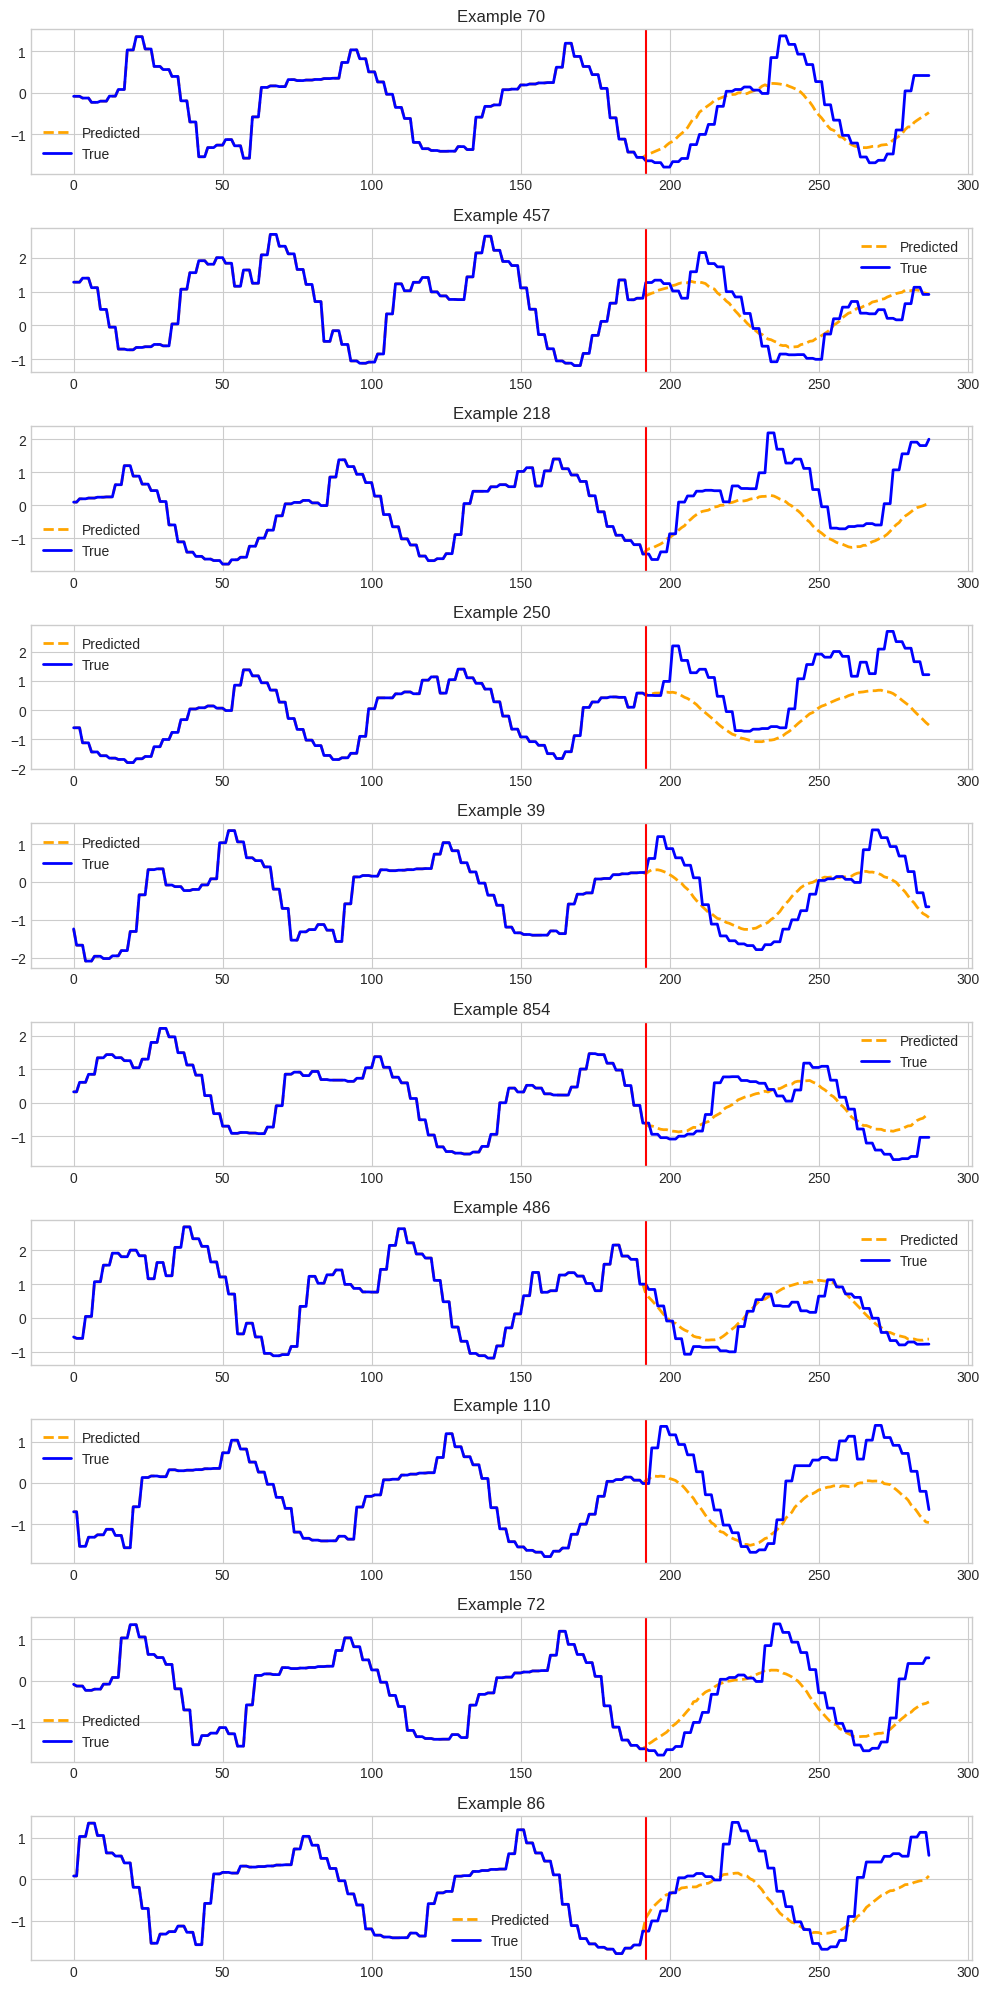

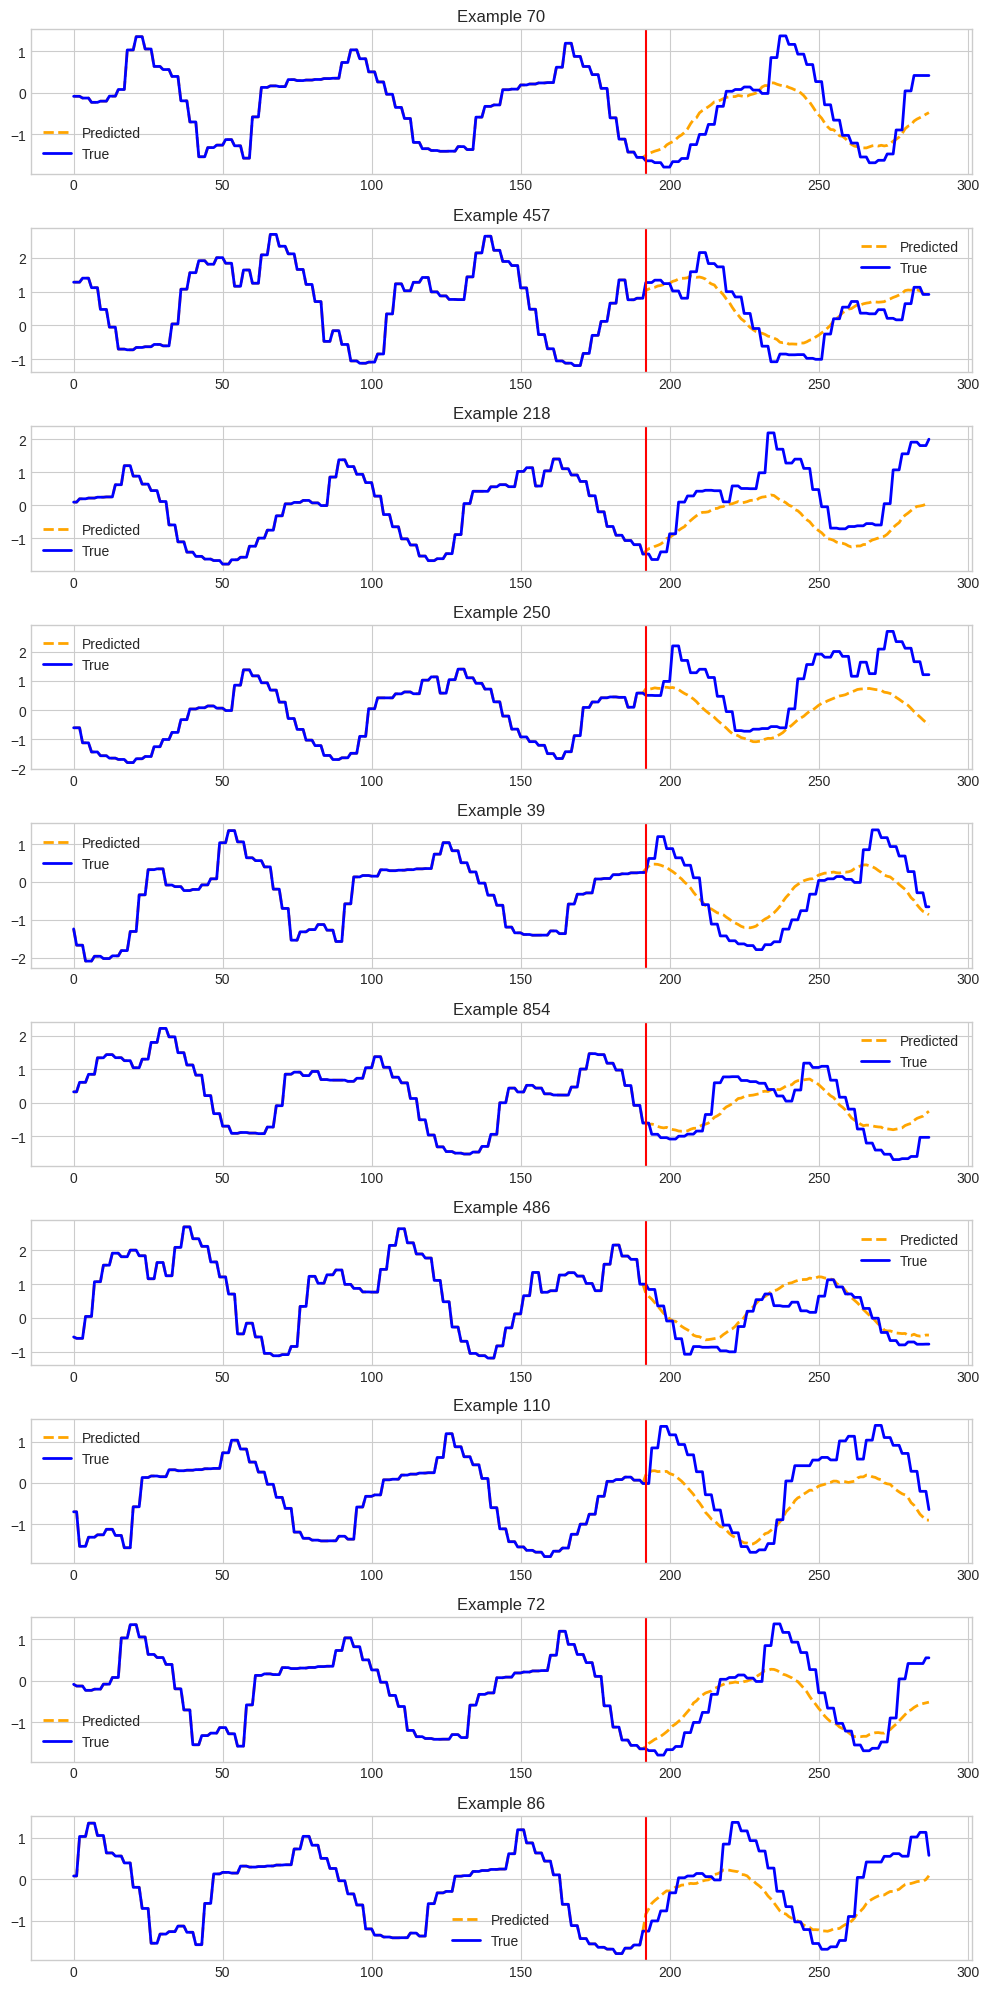

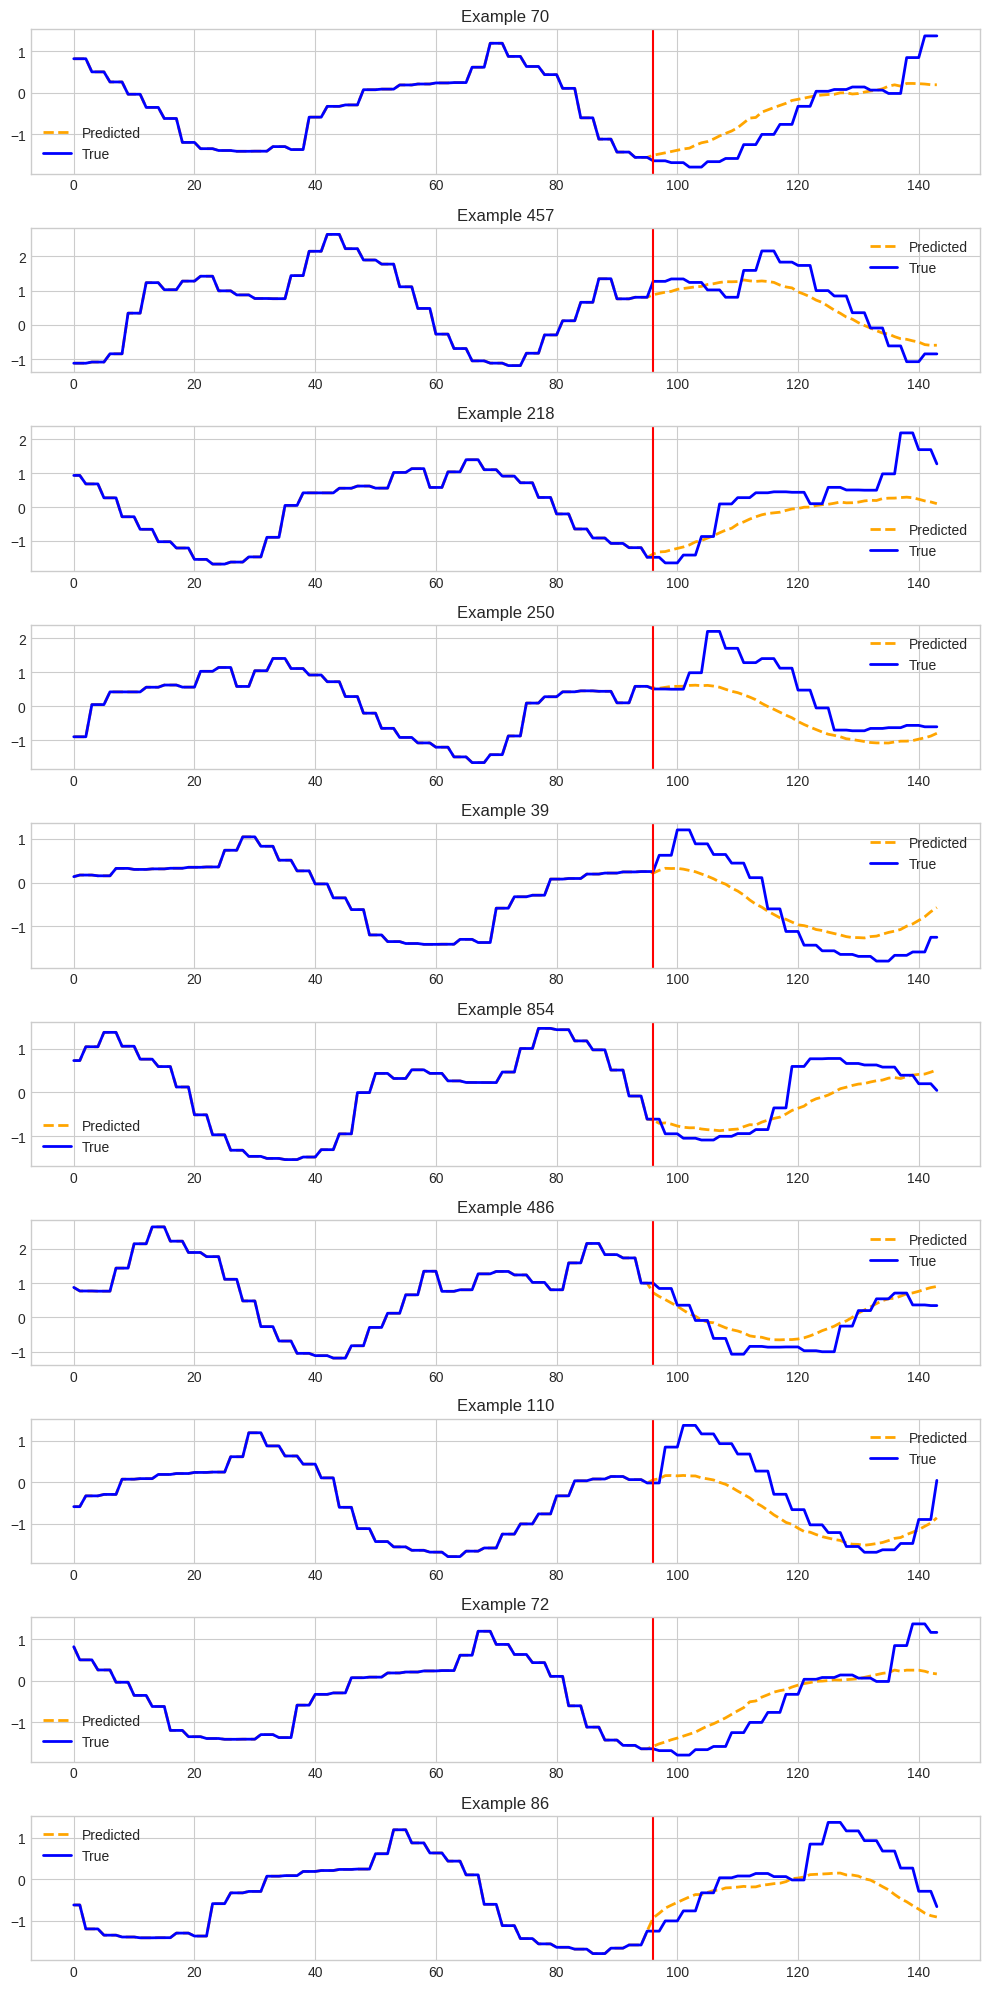

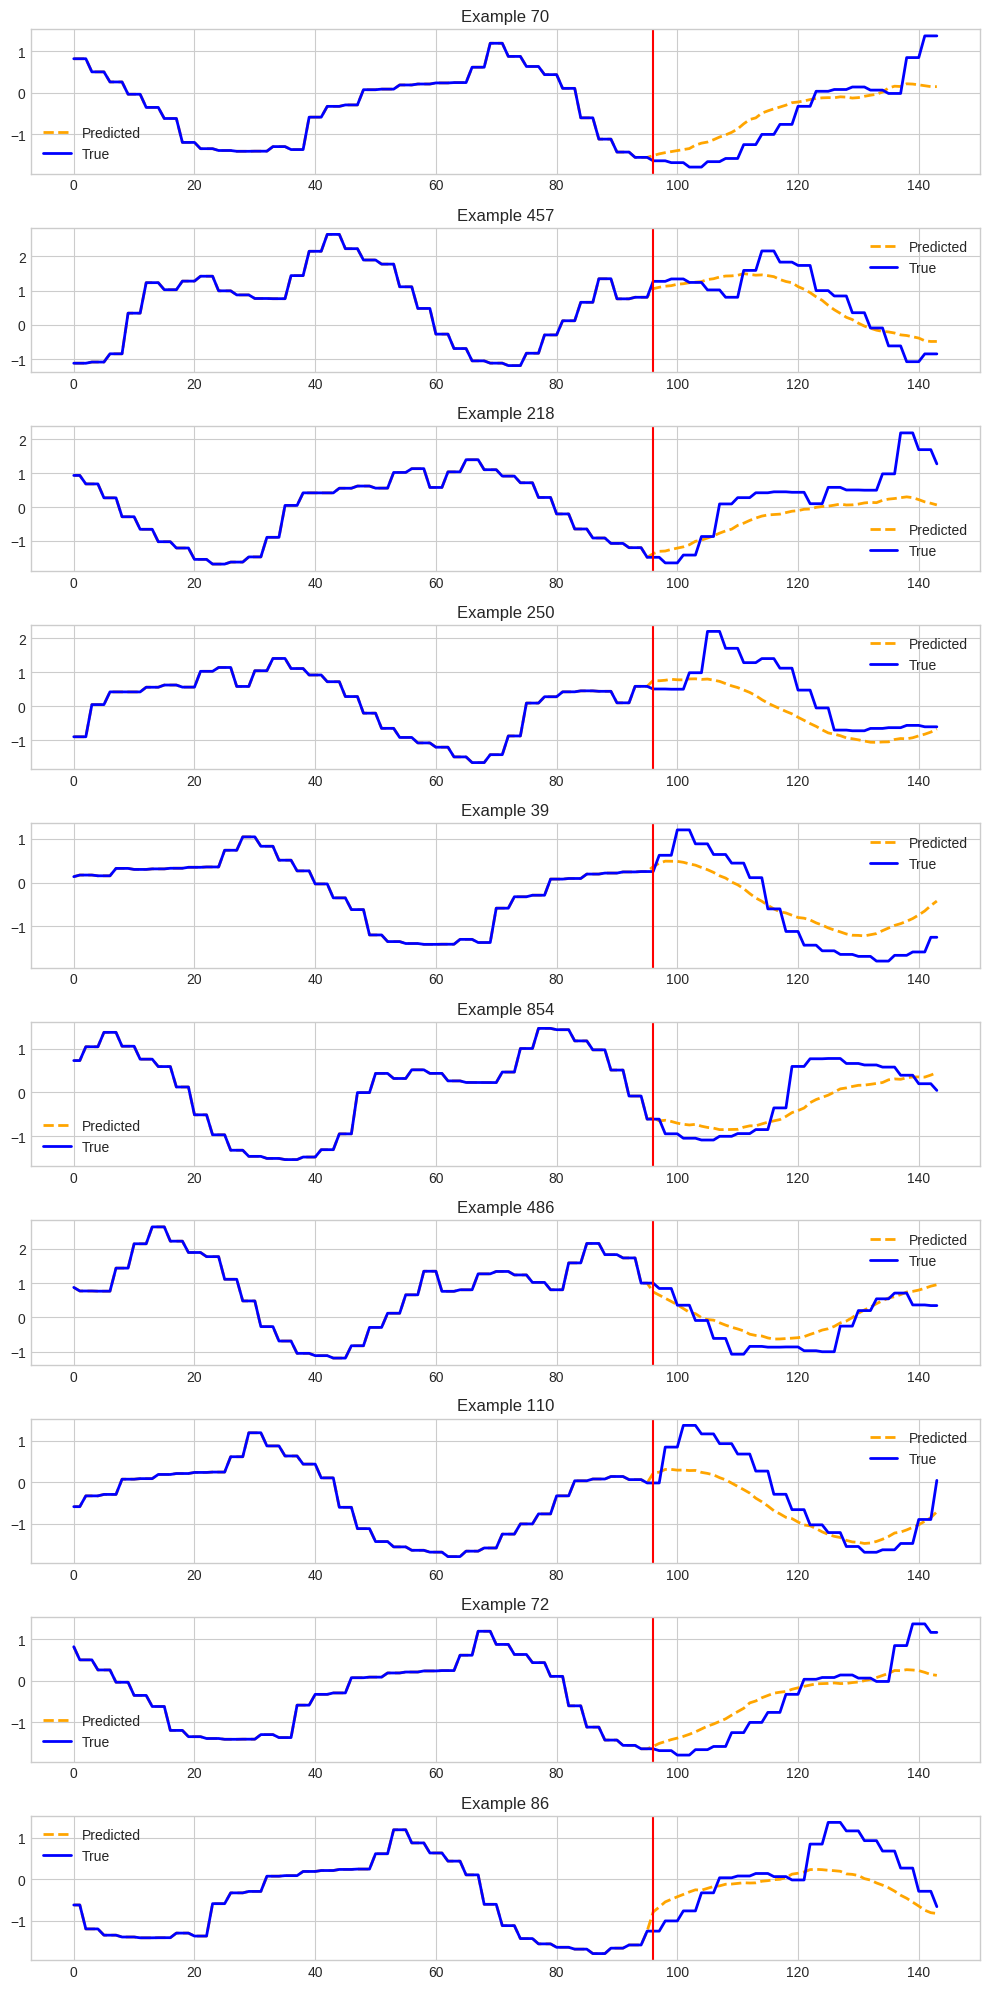

In [ ]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
TTM_MODEL_REVISION = "main"

# Path to your dataset
dataset_path = "/content/small.xlsx"

# Load the data
df_tmp = pd.read_excel(dataset_path)
df_tmp['ds'] = pd.to_datetime(df_tmp['ds'])

# Artificially increase dataset size for demonstration
df_tmp = pd.concat([df_tmp] * 10, ignore_index=True)

# Display the first few rows of the dataframe
print(df_tmp.head())

# Define the column specifiers
timestamp_column = "ds"
id_columns = []  # Adjust based on your dataset
target_columns = df_tmp.columns[1:].tolist()

# Define the split configuration
split_config = {
    "train": [0, int(0.6 * len(df_tmp))],
    "valid": [int(0.6 * len(df_tmp)), int(0.8 * len(df_tmp))],
    "test": [int(0.8 * len(df_tmp)), len(df_tmp)],
}

# Preprocess the dataset
data = df_tmp.copy()
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=512,
    prediction_length=96,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=0.05, fewshot_location="first"
)

print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

def zeroshot_eval(
    dset_test,
    batch_size,
    context_length=512,
    forecast_length=96,
    prediction_filter_length=None
):
    # Load model
    if prediction_filter_length is None:
        zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION
        )
    else:
        if prediction_filter_length <= forecast_length:
            zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION, prediction_filter_length=prediction_filter_length
            )
        else:
            raise ValueError(f"`prediction_filter_length` should be <= `forecast_length`")

    temp_dir = tempfile.mkdtemp()

    # Zero-shot trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
        )
    )

    # Evaluate zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # Plot predictions
    num_plots = min(10, len(dset_test))
    plot_preds(trainer=zeroshot_trainer, dset=dset_test, plot_dir=os.path.join(OUT_DIR, "your_dataset"), plot_prefix="test_zeroshot", channel=0, num_plots=num_plots)

def fewshot_finetune_eval(
    dset_train, dset_val, dset_test,
    batch_size,
    learning_rate=0.001,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    prediction_filter_length=None
):
    out_dir = os.path.join(save_dir, "your_dataset")

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Load model with appropriate configuration
    finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
        "ibm-granite/granite-timeseries-ttm-v1",
        revision=TTM_MODEL_REVISION,
        prediction_filter_length=prediction_filter_length if prediction_filter_length is not None else forecast_length
    )

    if freeze_backbone:
        print("Number of params before freezing backbone", count_parameters(finetune_forecast_model))

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        print("Number of params after freezing the backbone", count_parameters(finetune_forecast_model))

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to=None,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
    )

    # Early stopping and tracking callbacks
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,
        early_stopping_threshold=0.0,
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / batch_size),
    )

    # Fine-tune trainer
    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )

    # Fine-tune the model
    finetune_forecast_trainer.train()

    # Evaluate fine-tuned model
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # Plot predictions
    num_plots = min(10, len(dset_test))
    plot_preds(trainer=finetune_forecast_trainer, dset=dset_test, plot_dir=os.path.join(OUT_DIR, "your_dataset"), plot_prefix="test_fewshot", channel=0, num_plots=num_plots)

# Run zero-shot evaluation
zeroshot_eval(test_dataset, batch_size=64)
# Run few-shot fine-tuning and evaluation
fewshot_finetune_eval(train_dataset, valid_dataset, test_dataset, batch_size=64)

# Run zero-shot evaluation with prediction filter length
zeroshot_eval(test_dataset, batch_size=64, prediction_filter_length=48)
# Run few-shot fine-tuning and evaluation with prediction filter length
fewshot_finetune_eval(train_dataset, valid_dataset, test_dataset, batch_size=64, prediction_filter_length=48)


In [ ]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
TTM_MODEL_REVISION = "main"

# Path to your dataset
dataset_path = "/content/combined_dataset.xlsx"

# Load the data
df_tmp = pd.read_excel(dataset_path)
df_tmp['ds'] = pd.to_datetime(df_tmp['ds'])

# Artificially increase dataset size for demonstration
df_tmp = pd.concat([df_tmp] * 10, ignore_index=True)

# Display the first few rows of the dataframe
print(df_tmp.head())

# Define the column specifiers
timestamp_column = "ds"
id_columns = []  # Adjust based on your dataset
target_columns = df_tmp.columns[1:].tolist()

# Define the split configuration
split_config = {
    "train": [0, int(0.6 * len(df_tmp))],
    "valid": [int(0.6 * len(df_tmp)), int(0.8 * len(df_tmp))],
    "test": [int(0.8 * len(df_tmp)), len(df_tmp)],
}

# Preprocess the dataset
data = df_tmp.copy()
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=512,
    prediction_length=96,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=0.05, fewshot_location="first"
)

print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

def zeroshot_eval(
    dset_test,
    batch_size,
    context_length=512,
    forecast_length=96,
    prediction_filter_length=None
):
    # Load model
    if prediction_filter_length is None:
        zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION
        )
    else:
        if prediction_filter_length <= forecast_length:
            zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION, prediction_filter_length=prediction_filter_length
            )
        else:
            raise ValueError(f"`prediction_filter_length` should be <= `forecast_length`")

    temp_dir = tempfile.mkdtemp()

    # Zero-shot trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
        )
    )

    # Evaluate zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # Plot predictions
    num_plots = min(10, len(dset_test))
    plot_preds(trainer=zeroshot_trainer, dset=dset_test, plot_dir=os.path.join(OUT_DIR, "your_dataset"), plot_prefix="test_zeroshot", channel=0, num_plots=num_plots)

def fewshot_finetune_eval(
    dset_train, dset_val, dset_test,
    batch_size,
    learning_rate=0.001,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    prediction_filter_length=None
):
    out_dir = os.path.join(save_dir, "your_dataset")

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Load model with appropriate configuration
    finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
        "ibm-granite/granite-timeseries-ttm-v1",
        revision=TTM_MODEL_REVISION,
        prediction_filter_length=prediction_filter_length if prediction_filter_length is not None else forecast_length
    )

    if freeze_backbone:
        print("Number of params before freezing backbone", count_parameters(finetune_forecast_model))

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        print("Number of params after freezing the backbone", count_parameters(finetune_forecast_model))

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to=None,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
    )

    # Early stopping and tracking callbacks
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,
        early_stopping_threshold=0.0,
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / batch_size),
    )

    # Fine-tune trainer
    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )

    # Fine-tune the model
    finetune_forecast_trainer.train()

    # Evaluate fine-tuned model
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # Plot predictions
    num_plots = min(10, len(dset_test))
    plot_preds(trainer=finetune_forecast_trainer, dset=dset_test, plot_dir=os.path.join(OUT_DIR, "your_dataset"), plot_prefix="test_fewshot", channel=0, num_plots=num_plots)

# Run zero-shot evaluation
zeroshot_eval(test_dataset, batch_size=64)
# Run few-shot fine-tuning and evaluation
fewshot_finetune_eval(train_dataset, valid_dataset, test_dataset, batch_size=64)

# Run zero-shot evaluation with prediction filter length
zeroshot_eval(test_dataset, batch_size=64, prediction_filter_length=48)
# Run few-shot fine-tuning and evaluation with prediction filter length
fewshot_finetune_eval(train_dataset, valid_dataset, test_dataset, batch_size=64, prediction_filter_length=48)


                   ds     AREA13     AREA17    AREA18     AREA19      AREA20  \
0 2011-01-01 00:00:00  88.074635  72.479303  18.82104  138.61838  257.857343   
1 2011-01-01 01:00:00  85.638316  71.626921  18.08736  137.12338  254.185227   
2 2011-01-01 02:00:00  84.130155  70.904240  17.47680  135.78402  251.299487   
3 2011-01-01 03:00:00  83.078551  69.762638  17.08464  134.79082  246.884896   
4 2011-01-01 04:00:00  83.425287  69.225483  16.79184  133.73284  244.874204   

     AREA21    AREA22     AREA23     AREA24  ...     AREA57       AREA6  \
0  84.96768  27.27024  26.277332  61.375534  ...  59.015744  985.524051   
1  83.56032  26.63632  25.391039  61.292160  ...  56.509702  939.363308   
2  82.72968  26.59756  25.011245  60.986664  ...  54.802931  902.659208   
3  82.10364  26.22180  24.679159  60.839997  ...  53.585662  881.018019   
4  81.47784  26.14608  24.679125  61.194108  ...  53.058469  873.526001   

        AREA60      Calgary      Central     Edmonton    Northeast  

{'eval_loss': 0.1590629667043686, 'eval_runtime': 442.0209, 'eval_samples_per_second': 508.711, 'eval_steps_per_second': 7.95}
-------------------- Running few-shot 5% --------------------
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.144900,0.160376
2,0.140600,0.177548
3,0.138800,0.197672
4,0.137400,0.222105


Epoch,Training Loss,Validation Loss
1,0.144900,0.160376
2,0.140600,0.177548
3,0.138800,0.197672
4,0.137400,0.222105
